testing 2

# Packages and Functions

In [2]:
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
def create_dfs(folder_path, naics_name):
    list_dfs = []
    files = sorted(os.listdir(folder_path))
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path, file))
            df.rename(columns={naics_name + '_TRACTCE': 'Target_TRACT', 
                                'Home_TRACTCE': 'Home_TRACT',
                                'School_LON': 'Target_LON',
                                'School_LAT': 'Target_LAT'}, inplace=True)
            list_dfs.append(df)
    return list_dfs

    
def get_end_dates(list_dfs):
    dates = []
    for df in list_dfs:
        dates.append(df['date_range_end'].iloc[0])
    return dates

def get_tracts(list_dfs):
    df_combined = pd.concat(list_dfs)
    tracts = np.unique(df_combined[['Home_TRACT', 'Target_TRACT']].values)
    return tracts

def get_distances(list_dfs):
    df_combined = pd.concat(list_dfs)
    distances = np.unique(df_combined[['Distance_Covered (km)']].values)
    # Fix Distance_Covered for POI_TRACTCE == Home_TRACTCE
    #for df in list_dfs:
    #    df.loc[df[poi_name + '_TRACTCE'] == df['Home_TRACTCE'], 'Distance_Covered (km)'] = .02
    return distances

def print_df_info(list_dfs):
    dates =  get_end_dates(list_dfs)
    tracts = get_tracts(list_dfs)
    distances = get_distances(list_dfs)
    df_combined = pd.concat(list_dfs)
    pd.set_option('display.width', 1000)
    print('Number of Unique Tracts: \n', len(tracts))
    print('\nEnd Dates: \n', dates)
    print('\nSmallest Distance: \n', min(distances))
    print('\nLargest Distance: \n', max(distances))
    return None

def get_sparse_matrix(df, tracts): #row index = home, col index = target
    num_tracts = len(tracts)
    directed_matrix = np.zeros((num_tracts, num_tracts),dtype=float)
    for index, row in df.iterrows():
        home_index = np.where(tracts == row['Home_TRACT'])[0][0]
        school_index = np.where(tracts == row['Target_TRACT'])[0][0]
        directed_matrix[home_index, school_index] = row['Visitor_Count']
    sparse_matrix = csr_matrix(directed_matrix)
    return sparse_matrix

def get_weighted_adjacency_matrices(list_dfs, tracts):
    mats = []
    for df in list_dfs:
        mats.append(get_sparse_matrix(df, tracts))
    return mats

def get_node_degrees_in(list_mats):
    degrees = []
    for mat in list_mats:
        sums = np.array(mat.sum(axis=0)).flatten()
        degrees.append(sums)
    degrees = np.array(degrees)
    return degrees

def get_node_degrees_out(list_mats):
    degrees = []
    for mat in list_mats:
        sums = np.array(mat.sum(axis=1)).flatten()
        degrees.append(sums)
    degrees = np.array(degrees)
    return degrees

def get_histogram_data(list_arrays, num_bins):
    counts = []
    bins = []
    dists = []
    for arr in list_arrays:
        c, b = np.histogram(arr, num_bins)
        d = c/sum(c)/(b[1]-b[0])
        counts.append(c)
        bins.append(b)
        dists.append(d)
    counts = np.array(counts)
    bins = np.array(bins)
    dists = np.array(dists)
    return counts, bins, dists

def plot_degree_counts(deg, means, stds, labels, ax):
    num_weeks = np.shape(deg)[0]
    num_tracts = np.shape(deg)[1]
    x = np.linspace(1,num_weeks,num_weeks) #plt.violinplot starts with index 1

    ax.plot(x, means, color='b')
    ax.plot(x, means+stds, alpha=0.2)
    ax.fill_between(x, means, means+stds, color='b', alpha=0.2)
    ax.fill_between(x, means, means-stds, color='b', alpha=0.2)

    for i in range(0,num_weeks):
        ax.scatter(np.full((num_tracts,), x[i]), deg[i,:], s=3, color='c')

    ax.violinplot(deg.T, showextrema=False, showmeans=False)
    #plt.errorbar(np.arange(1, 12 + 1), means, yerr=std,  color='red', label='Standard Deviation')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels, rotation='vertical')
    ax.set_xlabel('Week End Date')  # Set x-axis label
    ax.set_ylabel('Degree Counts')
    #ax.legend()

def plot_degree_distribution(bins, distributions, labels, ax):
    colors = np.full((12,), 'b')
    colors[0] = 'g'
    colors[7] = 'r'
    colors[11] = 'c'
    alphas = np.full((12,), .1)
    alphas[0] = 1
    alphas[7] = 1
    alphas[11] = 1

    for i in range(len(labels)):
        ax.loglog(bins[i, 1:], distributions[i, :], 'x', label = labels[i], color=colors[i], alpha=alphas[i])

    ax.set_ylabel('Probability')
    ax.set_xlabel('Degree')
    ax.legend(fontsize=7)
    
def big_kahuna(folder_path, NAICS_name):
    dfs = create_dfs(folder_path, NAICS_name)
    dates = get_end_dates(dfs)
    tracts = get_tracts(dfs)
    distances = get_distances(dfs)
    mats = get_weighted_adjacency_matrices(dfs, tracts)
    degrees_in = get_node_degrees_in(mats)
    degrees_out = get_node_degrees_out(mats)
    weekly_means_in = np.mean(degrees_in, axis=1)
    weekly_stds_in = np.std(degrees_in, axis=1)
    weekly_means_out = np.mean(degrees_out, axis=1)
    weekly_stds_out = np.std(degrees_out, axis=1)
    num_bins = 10
    counts_in, bins_in, distributions_in = get_histogram_data(degrees_in, num_bins)
    counts_out, bins_out, distributions_out = get_histogram_data(degrees_out, num_bins)

    fig, ax = plt.subplots(1,4, figsize=(8,8))
    plot_degree_counts(degrees_in, weekly_means_in, weekly_stds_in, dates, ax[0])
    ax[0].set_title('In-Degrees')
    plot_degree_counts(degrees_out, weekly_means_out, weekly_stds_out, dates, ax[1])
    ax[1].set_title('Out-Degrees')
    plot_degree_distribution(bins_in, distributions_in, dates, ax[2])
    ax[2].set_title('In-Degrees')
    plot_degree_distribution(bins_out, distributions_out, dates, ax[3])
    ax[3].set_title('Out-Degrees')

    fig.tight_layout()
    plt.show()

    return None

# Setting up dataframes
From a folder containing .csv files, create a list of dataframes. (The target NAICS name is inputted, but changed to 'Target' for general use. Might want to change this in Francis's code.)

In [4]:
folder_path = '../data/schools'
NAICS_name = 'School'
schools_dfs = create_dfs(folder_path, NAICS_name)
schools_dfs[0].head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/schools'

# Get unique dates, tracts, and distances. 

Also, print relevant information about the data. (Can add more, if needed)

In [116]:
dates = get_end_dates(schools_dfs)
tracts = get_tracts(schools_dfs)
distances = get_distances(schools_dfs)
print_df_info(schools_dfs)

Number of Unique Tracts: 
 485

End Dates: 
 ['2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08', '2021-03-15', '2021-03-22']

Smallest Distance: 
 0.0210855084502621

Largest Distance: 
 95.30126058401514


# Weighted adjacency matrices

Returns a list of matrices, one matrix for each week. Entry (i,j) represents visitor counts from Home_TRACT[i] to School_TRACT[j]. 

In [117]:
schools_mats = get_weighted_adjacency_matrices(schools_dfs, tracts)

# Looking at node degrees

We can look at in-degrees (visitor counts to target tracts) and out-degrees (visitor counts from home tracts).

In [118]:
degrees_in = get_node_degrees_in(schools_mats)
degrees_out = get_node_degrees_out(schools_mats)

Needed calculations for the plots below. (Maybe make into a function?)

In [120]:
weekly_means_in = np.mean(degrees_in, axis=1)
weekly_stds_in = np.std(degrees_in, axis=1)
weekly_means_out = np.mean(degrees_out, axis=1)
weekly_stds_out = np.std(degrees_out, axis=1)

num_bins = 10
counts_in, bins_in, distributions_in = get_histogram_data(degrees_in, num_bins)
counts_out, bins_out, distributions_out = get_histogram_data(degrees_out, num_bins)

Plot node degrees, using a violin plot.

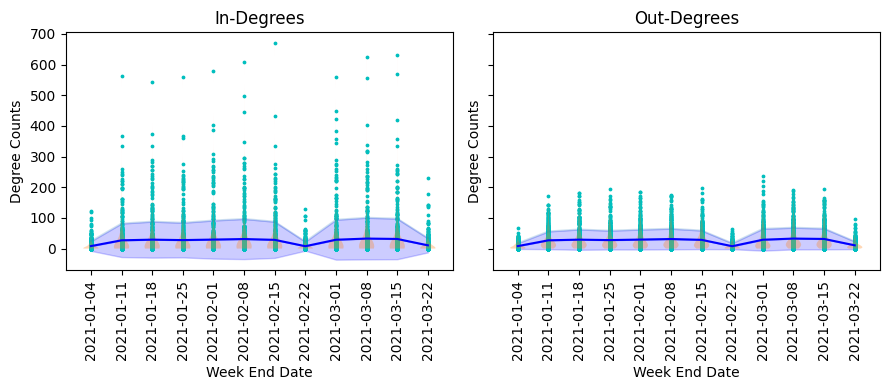

In [121]:
fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
plot_degree_counts(degrees_in, weekly_means_in, weekly_stds_in, dates, ax[0])
ax[0].set_title('In-Degrees')
plot_degree_counts(degrees_out, weekly_means_out, weekly_stds_out, dates, ax[1])
ax[1].set_title('Out-Degrees')

fig.tight_layout()
plt.show()

Plot distribution of nodes. (Anomalous weeks are hard-coded in, maybe fix this for a more general case.)

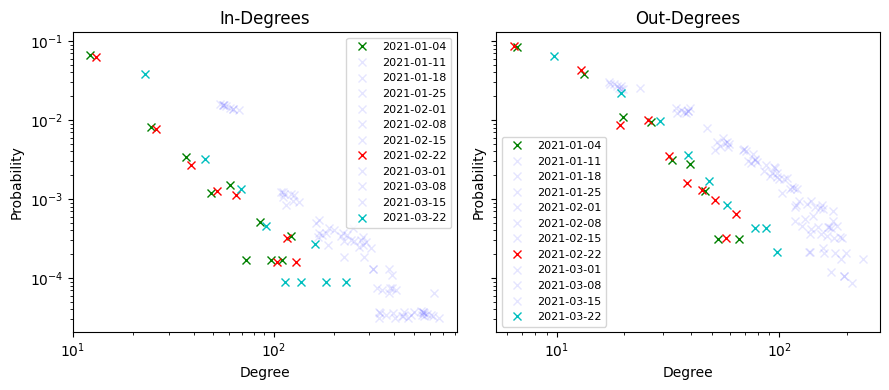

In [122]:
fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
plot_degree_distribution(bins_in, distributions_in, dates, ax[0])
ax[0].set_title('In-Degrees')
plot_degree_distribution(bins_out, distributions_out, dates, ax[1])
ax[1].set_title('Out-Degrees')

fig.tight_layout()
plt.show()

# Everything together

Not sure, if this is helpful or not.

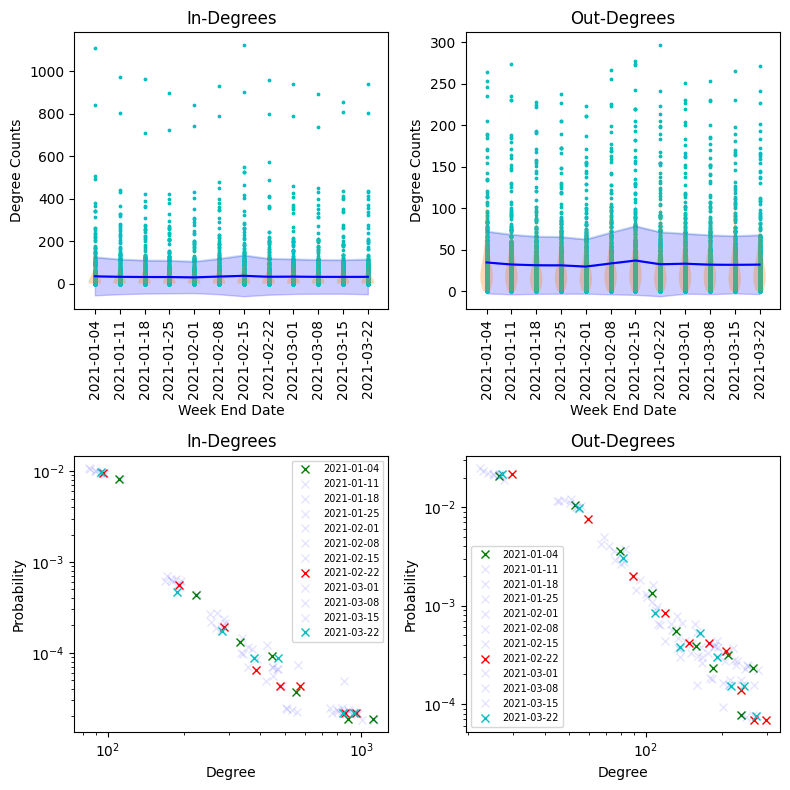

In [8]:
NAICS_name = 'Groceries'
folder_path = '../data/Groceries'

big_kahuna(folder_path, NAICS_name)

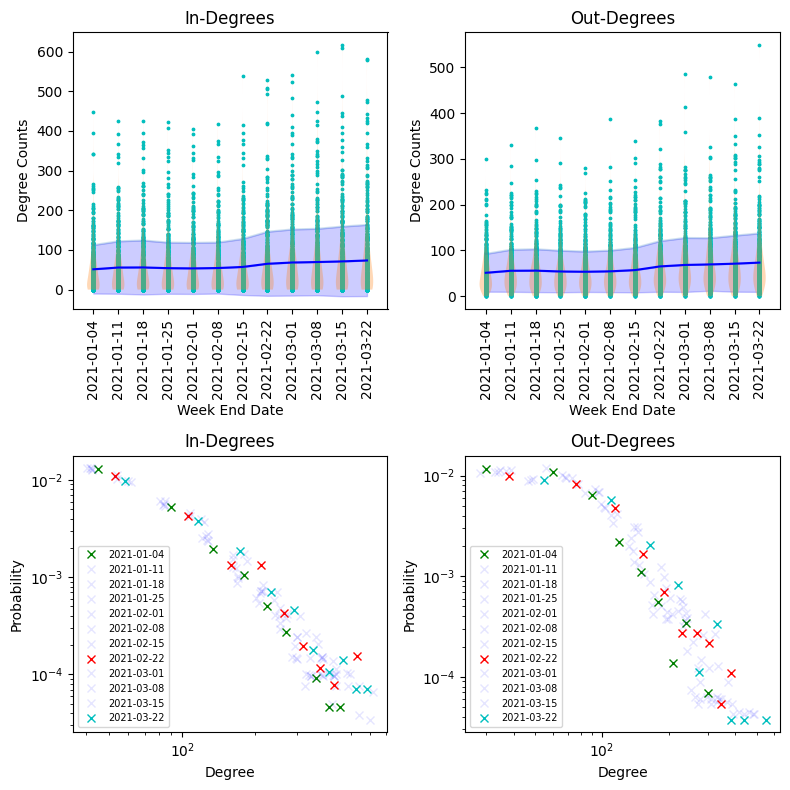

In [7]:
NAICS_name = 'Groceries'
folder_path = '../data/Convenience'

big_kahuna(folder_path, NAICS_name)